MACSS 30200

HW#2

Delores Tang

In [27]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

import matplotlib.pyplot as plt

## Major requirements
### 1. Import the data and tokenize to use with Keras

In [10]:
# Import train, validation, and test data
congress_train = pd.read_csv('data/congress_train.csv').dropna()
congress_val = pd.read_csv('data/congress_val.csv').dropna()
congress_test = pd.read_csv('data/congress_test.csv').dropna()

# Convert Title into lists of strings
def to_str(data):
    to_lst = list(data["Title"])
    to_lst_str = [str(i) for i in to_lst]
    return to_lst_str

train_str = to_str(congress_train)
val_str = to_str(congress_val)
test_str = to_str(congress_test)

# Update token vocabularies
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train_str)

# Transform list of strings to list of word sequences
train_seq = []
for lst in train_str:
    seq = text_to_word_sequence(lst)
    train_seq.append(seq)
word_idx = tokenizer.word_index

# Tokenize word strings and pad to length 100
def to_tokens(text_data):
    to_seq = tokenizer.texts_to_sequences(text_data)
    x_data = pad_sequences(to_seq, maxlen = 100)
    return x_data

X_train = to_tokens(train_str)
X_val = to_tokens(val_str)
X_test = to_tokens(test_str)

# Preprocess output variable to categorical
y_train = to_categorical(list(congress_train['Major']))
y_val = to_categorical(list(congress_val['Major']))
y_test = to_categorical(list(congress_test['Major']))

### 2. Use a task-specific embedding layer with an appropriate number of output dimensions 

I used Word2Vec for embeddings. Word2Vec could be built on two architectures, either based on CBOW or on Skip-Gram model. The two resulted embedding matrices will be analyzed separately as alternative models later. 

In [50]:
import gensim
from gensim.models import word2vec

# CBOW-based Word2Vec
mod_cbow = word2vec.Word2Vec(train_seq, size = 50, sg = 0)
mod_cbow_wv = mod_cbow.wv

EmbedMat_cbow = np.zeros((10000, 50))
for word, i in word_idx.items():
    if i < 10000:
        embed_vec = mod_cbow.wv[word]
        if embed_vec is not None:
            EmbedMat_cbow[i] = embed_vec

In [51]:
# SG-based Word2Vec
mod_sg = word2vec.Word2Vec(train_seq, size = 50, sg = 1)
mod_sg_wv = mod_sg.wv

EmbedMat_sg = np.zeros((10000, 50))
for word, i in word_idx.items():
    if i < 10000:
        embed_vec = mod_sg.wv[word]
        if embed_vec is not None:
            EmbedMat_sg[i] = embed_vec

### 3. Use a basic feed-forward network

In [23]:
ff_init = Sequential()
ff_init.add(Embedding(10000, 50, input_length=100))
ff_init.add(Flatten())
ff_init.add(Dense(24, activation='softmax'))
ff_init.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
ff_init.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                120024    
Total params: 620,024
Trainable params: 620,024
Non-trainable params: 0
_________________________________________________________________


In [24]:
result_init = ff_init.fit(X_train, y_train,epochs=50, batch_size=512, validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 278612 samples, validate on 69649 samples
Epoch 1/50
278612/278612 [==============================] - 5s 16us/step - loss: 1.5931 - acc: 0.5726 - val_loss: 0.8551 - val_acc: 0.7743
Epoch 2/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.7069 - acc: 0.8105 - val_loss: 0.6610 - val_acc: 0.8231
Epoch 3/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.5814 - acc: 0.8408 - val_loss: 0.6099 - val_acc: 0.8361
Epoch 4/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.5211 - acc: 0.8562 - val_loss: 0.5866 - val_acc: 0.8425
Epoch 5/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.4799 - acc: 0.8676 - val_loss: 0.5721 - val_acc: 0.8479
Epoch 6/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.4479 - acc: 0.8759 - val_loss: 0.5662 - val_acc: 0.8495
Epoch 7/50
278612/278612 [==============================] - 3s 12us

In [25]:
ff_init_dict = result_init.history
ff_init_acc = ff_init_dict['val_acc'] 
ff_init_loss = ff_init_dict['val_loss']

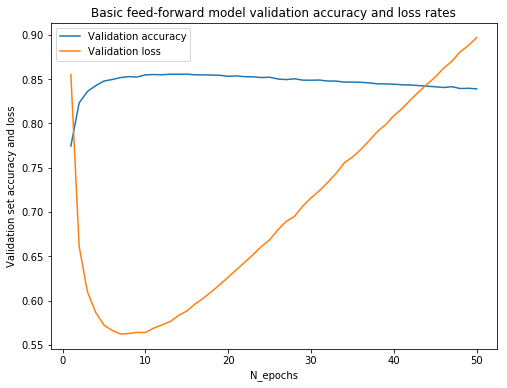

In [28]:
n_epochs = np.arange(1, 51)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, ff_init_acc, label='Validation accuracy')
plt.plot(n_epochs, ff_init_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Basic feed-forward model validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 4. Estimate a recurrent neural network (RNN) with a layer_simple_rnn

In [31]:
from keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(Embedding(10000, 50, input_length=100))
rnn.add(SimpleRNN(50))
rnn.add(Dense(24, activation='softmax'))
rnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_rnn = rnn.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=512)

Train on 278612 samples, validate on 69649 samples
Epoch 1/50
278612/278612 [==============================] - 46s 166us/step - loss: 1.8536 - acc: 0.4757 - val_loss: 1.2513 - val_acc: 0.6482
Epoch 2/50
278612/278612 [==============================] - 46s 164us/step - loss: 0.9543 - acc: 0.7545 - val_loss: 0.9794 - val_acc: 0.7410
Epoch 3/50
278612/278612 [==============================] - 46s 164us/step - loss: 0.7684 - acc: 0.8017 - val_loss: 0.8697 - val_acc: 0.7693
Epoch 4/50
278612/278612 [==============================] - 46s 163us/step - loss: 0.6839 - acc: 0.8224 - val_loss: 0.8554 - val_acc: 0.7795
Epoch 5/50
278612/278612 [==============================] - 46s 164us/step - loss: 0.6291 - acc: 0.8363 - val_loss: 0.6972 - val_acc: 0.8187
Epoch 6/50
278612/278612 [==============================] - 46s 163us/step - loss: 0.5857 - acc: 0.8462 - val_loss: 0.7314 - val_acc: 0.8093
Epoch 7/50
278612/278612 [==============================] - 46s 164us/step - loss: 0.5531 - acc: 0.8549

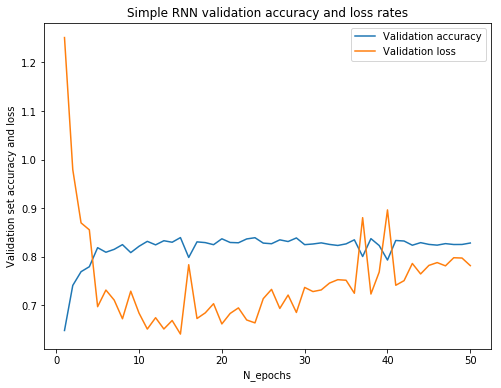

In [32]:
rnn_dict = result_rnn.history
rnn_val_acc = rnn_dict['val_acc'] 
rnn_val_loss = rnn_dict['val_loss']

n_epochs = np.arange(1, 51)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, rnn_val_acc, label='Validation accuracy')
plt.plot(n_epochs, rnn_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Simple RNN validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 5. Estimate an RNN with an LSTM layer

In [34]:
from keras.layers import LSTM
rnn_lstm = Sequential()
rnn_lstm.add(Embedding(10000, 50, input_length=100))
rnn_lstm.add(LSTM(50))
rnn_lstm.add(Dense(24, activation='softmax'))
rnn_lstm.summary()
rnn_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_lstm = rnn_lstm.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1224      
Total params: 521,424
Trainable params: 521,424
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 132s 474us/step - loss: 1.8522 - acc: 0.4819 - val_loss: 1.1739 - val_acc: 0.6905
Epoch 2/20
278612/278612 [==============================] - 131s 470us/step - loss: 0.8845 - acc: 0.7736 - val_loss: 0.8060 - val_acc: 0.7870
Epoch 3/20
278612/278612 [==============================] - 131s

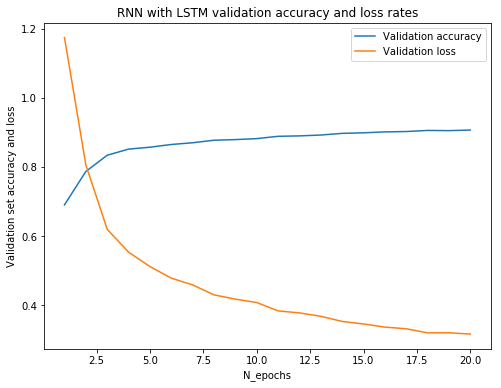

In [60]:
lstm_dict = result_lstm.history
lstm_val_acc = lstm_dict['val_acc'] 
lstm_val_loss = lstm_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, lstm_val_acc, label='Validation accuracy')
plt.plot(n_epochs, lstm_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('RNN with LSTM validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 6. Estimate an RNN with a GRU layer

In [37]:
from keras.layers import GRU
rnn_gru = Sequential()
rnn_gru.add(Embedding(10000, 50, input_length=100))
rnn_gru.add(GRU(50))
rnn_gru.add(Dense(24, activation='softmax'))
rnn_gru.summary()
rnn_gru.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_gru = rnn_gru.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1224      
Total params: 516,374
Trainable params: 516,374
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 107s 384us/step - loss: 2.1384 - acc: 0.3540 - val_loss: 1.5171 - val_acc: 0.5872
Epoch 2/20
278612/278612 [==============================] - 107s 383us/step - loss: 1.1516 - acc: 0.7053 - val_loss: 0.8433 - val_acc: 0.7846
Epoch 3/20
278612/278612 [==============================] - 106s

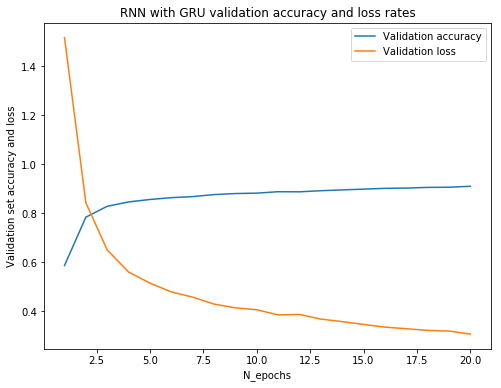

In [62]:
gru_dict = result_gru.history
gru_val_acc = gru_dict['val_acc'] 
gru_val_loss = gru_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, gru_val_acc, label='Validation accuracy')
plt.plot(n_epochs, gru_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('RNN with GRU validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 7. Estimate five additional neural network models with different configurations of hyperparameters (e.g. number of layers, number of hidden units, dropout, weight regularization, pre-trained word embeddings)

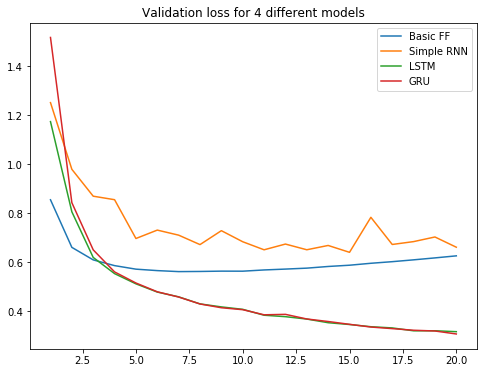

,0
Basic FF,0.700639
Simple RNN,0.748870
LSTM,0.466048
GRU,0.487145


In [61]:
model_lst = [result_init, result_rnn, result_lstm, result_gru]
models = ['Basic FF', 'Simple RNN', 'LSTM', 'GRU']

plt.figure(figsize = (8,6))
n_epochs = np.arange(1,21)
for mod in model_lst:
    plt.plot(n_epochs, mod.history['val_loss'][:20])

plt.legend(models, loc = "best")
plt.title('Validation loss for 4 different models')
plt.show()

avg_loss = [np.mean(mod.history['val_loss']) for mod in model_lst]
avg_loss_df = pd.DataFrame(avg_loss, models)
avg_loss_df

In [52]:
# Mod 1: RNN with LSTM using Word2Vec - CBOW architecture

mod1 = Sequential()
mod1.add(Embedding(10000, 50, input_length=100))
mod1.add(LSTM(50))
mod1.add(Dense(24, activation='softmax'))
mod1.layers[0].set_weights([EmbedMat_cbow])
mod1.layers[0].trainable = False
mod1.summary()
mod1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_mod1 = mod1.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1224      
Total params: 521,424
Trainable params: 521,424
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 128s 460us/step - loss: 1.3760 - acc: 0.6136 - val_loss: 0.9910 - val_acc: 0.7170
Epoch 2/20
278612/278612 [==============================] - 124s 447us/step - loss: 0.8982 - acc: 0.7427 - val_loss: 0.8377 - val_acc: 0.7589
Epoch 3/20
278612/278612 [==============================] - 126s

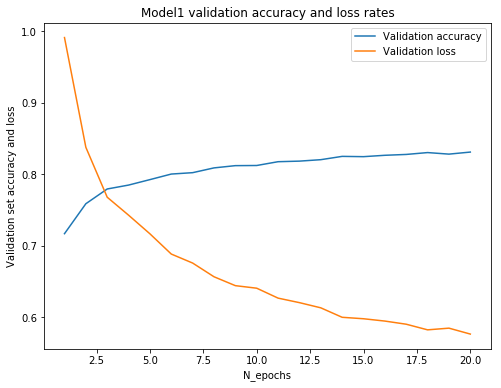

In [54]:
mod1_dict = result_mod1.history
mod1_val_acc = mod1_dict['val_acc'] 
mod1_val_loss = mod1_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, mod1_val_acc, label='Validation accuracy')
plt.plot(n_epochs, mod1_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Model1 validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

In [55]:
# Mod 2: RNN with LSTM using Word2Vec - SG architecture

mod2 = Sequential()
mod2.add(Embedding(10000, 50, input_length=100))
mod2.add(LSTM(50))
mod2.add(Dense(24, activation='softmax'))
mod2.layers[0].set_weights([EmbedMat_sg])
mod2.layers[0].trainable = False
mod2.summary()
mod2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_mod2 = mod2.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 24)                1224      
Total params: 521,424
Trainable params: 521,424
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 128s 458us/step - loss: 1.5667 - acc: 0.5514 - val_loss: 1.1724 - val_acc: 0.6645
Epoch 2/20
278612/278612 [==============================] - 125s 449us/step - loss: 1.0007 - acc: 0.7091 - val_loss: 0.9499 - val_acc: 0.7216
Epoch 3/20
278612/278612 [==============================] - 127s

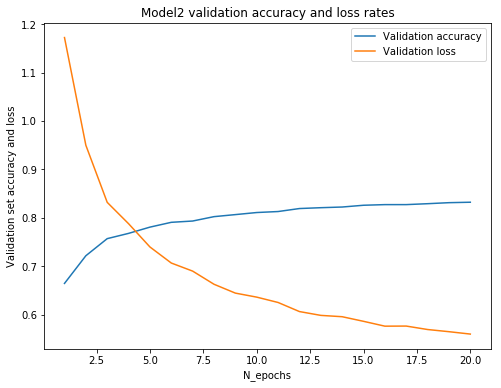

In [56]:
mod2_dict = result_mod2.history
mod2_val_acc = mod2_dict['val_acc'] 
mod2_val_loss = mod2_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, mod2_val_acc, label='Validation accuracy')
plt.plot(n_epochs, mod2_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Model2 validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

In [92]:
# Mod 3: RNN with stacked GRU using Word2Vec - SG architecture

mod3 = Sequential()
mod3.add(Embedding(10000, 50, input_length=100))
mod3.add(GRU(50, return_sequences = True))
mod3.add(GRU(50))
mod3.add(Dense(24, activation='softmax'))
mod3.layers[0].set_weights([EmbedMat_sg])
mod3.layers[0].trainable = False
mod3.summary()
mod3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_mod3 = mod3.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 50)           500000    
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 50)           15150     
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_21 (Dense)             (None, 24)                1224      
Total params: 531,524
Trainable params: 31,524
Non-trainable params: 500,000
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 207s 743us/step - loss: 1.4985 - acc: 0.5593 - val_loss: 1.0433 - val_acc: 0.6915
Epoch 2/20
278612/278612 [==============================] - 203s 730u

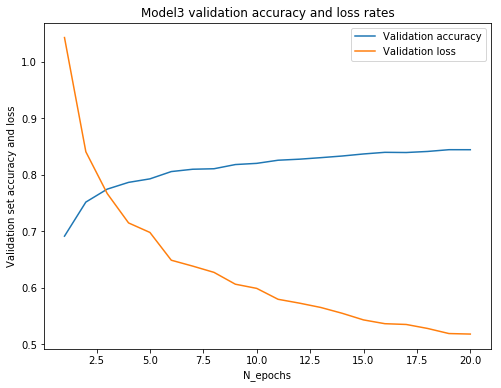

In [97]:
mod3_dict = result_mod3.history
mod3_val_acc = mod3_dict['val_acc'] 
mod3_val_loss = mod3_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, mod3_val_acc, label='Validation accuracy')
plt.plot(n_epochs, mod3_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Model3 validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

In [71]:
# Mod 4: RNN with stacked LSTM and dropout using Word2Vec - SG architecture

mod4 = Sequential()
mod4.add(Embedding(10000, 50, input_length=100))
mod4.add(LSTM(50, dropout = 0.1, recurrent_dropout = 0.3, return_sequences = True))
mod4.add(LSTM(50, dropout = 0.1, recurrent_dropout = 0.3))
mod4.add(Dense(24, activation='softmax'))
mod4.summary()
mod4.layers[0].set_weights([EmbedMat_sg])
mod4.layers[0].trainable = False
mod4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_mod4 = mod4.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 50)           500000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_19 (Dense)             (None, 24)                1224      
Total params: 541,624
Trainable params: 541,624
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 277s 993us/step - loss: 1.7182 - acc: 0.4997 - val_loss: 1.1256 - val_acc: 0.6734
Epoch 2/20
278612/278612 [==============================] - 273s 981us/ste

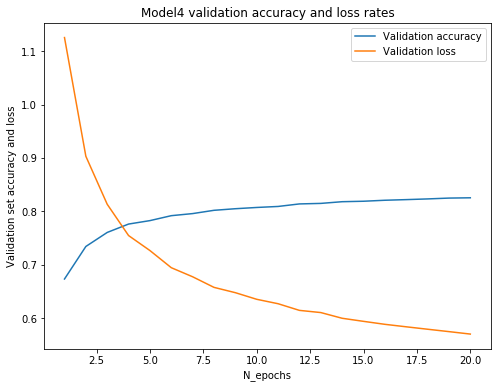

In [72]:
mod4_dict = result_mod4.history
mod4_val_acc = mod4_dict['val_acc'] 
mod4_val_loss = mod4_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, mod4_val_acc, label='Validation accuracy')
plt.plot(n_epochs, mod4_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Model4 validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

In [74]:
from keras import regularizers

# Mod 5: RNN with stacked LSTM, l2 regularization of 0.001 and dropout using Word2Vec - CBOW architecture

mod5 = Sequential()
mod5.add(Embedding(10000, 50, input_length=100))
mod5.add(LSTM(50, kernel_regularizer=regularizers.l2(0.001), return_sequences = True))
mod5.add(LSTM(50, kernel_regularizer=regularizers.l2(0.001)))
mod5.add(Dense(24, activation='softmax'))
mod5.layers[0].set_weights([EmbedMat_cbow])
mod5.layers[0].trainable = False
mod5.summary()
mod5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
result_mod5 = mod5.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 50)           500000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_20 (Dense)             (None, 24)                1224      
Total params: 541,624
Trainable params: 41,624
Non-trainable params: 500,000
_________________________________________________________________
Train on 278612 samples, validate on 278612 samples
Epoch 1/20
278612/278612 [==============================] - 258s 926us/step - loss: 1.5145 - acc: 0.6073 - val_loss: 1.2554 - val_acc: 0.6718
Epoch 2/20
278612/278612 [==============================] - 253s 908u

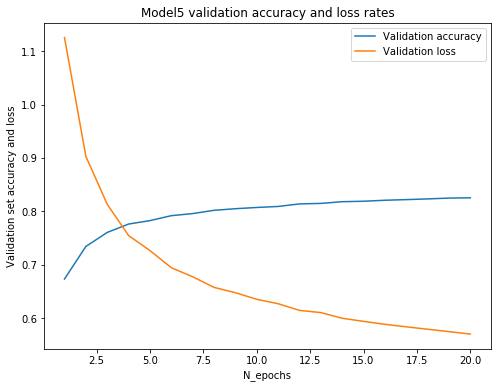

In [75]:
mod5_dict = result_mod5.history
mod5_val_acc = mod5_dict['val_acc'] 
mod5_val_loss = mod5_dict['val_loss']

n_epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(n_epochs, mod4_val_acc, label='Validation accuracy')
plt.plot(n_epochs, mod4_val_loss, label='Validation loss')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('N_epochs')
plt.title('Model5 validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 8. For each model, plot the validation loss and accuracy over each epoch.

Plotted all loss and accuracy in one graph. 

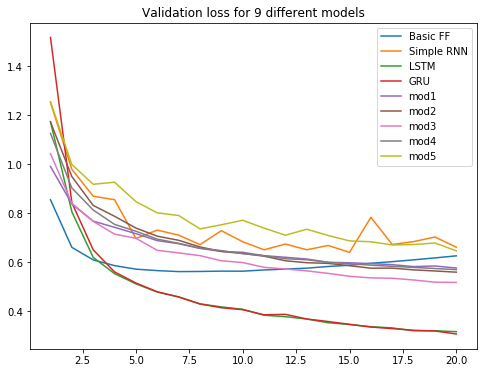

In [94]:
# Update model lists
model_lst = [result_init, result_rnn, result_lstm, result_gru, 
             result_mod1, result_mod2, result_mod3, result_mod4, result_mod5]
models = ['Basic FF', 'Simple RNN', 'LSTM', 'GRU', 'mod1', 'mod2', 'mod3', 'mod4', 'mod5']

plt.figure(figsize = (8,6))
n_epochs = np.arange(1,21)
for mod in model_lst:
    plt.plot(n_epochs, mod.history['val_loss'][:20])

plt.legend(models, loc = "best")
plt.title('Validation loss for 9 different models')
plt.show()

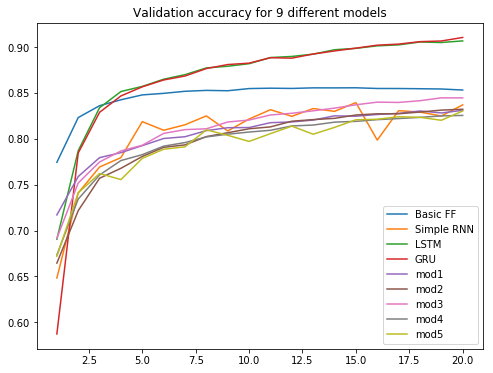

In [95]:
# Plot accuracy for all models
plt.figure(figsize = (8,6))
n_epochs = np.arange(1,21)
for mod in model_lst:
    plt.plot(n_epochs, mod.history['val_acc'][:20])

plt.legend(models, loc = "best")
plt.title('Validation accuracy for 9 different models')
plt.show()

In [96]:
avg_loss = [np.mean(mod.history['val_loss'][:20]) for mod in model_lst]
avg_acc = [np.mean(mod.history['val_acc'][:20]) for mod in model_lst]
min_loss = [min(mod.history['val_loss'][:20]) for mod in model_lst]
max_acc = [max(mod.history['val_acc'][:20]) for mod in model_lst]
summary_df = pd.DataFrame({
    'Model list'       : models,
    'Average loss'     : avg_loss,
    'Average accuracy' : avg_acc,
    'Min loss'         : min_loss,
    'Max accuracy'     : max_acc
})
print(summary_df)

   Average accuracy  Average loss  Max accuracy  Min loss  Model list
0          0.846684      0.602307      0.855619  0.562151    Basic FF
1          0.805747      0.748654      0.839452  0.640808  Simple RNN
2          0.869026      0.466048      0.906731  0.317199        LSTM
3          0.863417      0.487145      0.910478  0.307793         GRU
4          0.805918      0.667604      0.831027  0.576746        mod1
5          0.797203      0.683983      0.832204  0.559826        mod2
6          0.811424      0.631808      0.844630  0.518040        mod3
7          0.796081      0.678960      0.825485  0.570228        mod4
8          0.793835      0.786778      0.830327  0.646913        mod5


From the graph and the table, I select the RNN with GRU model as my best model. 

### 9. Select the best performing model based on the validation set and evaluate its performance using the test set. 

In [86]:
test_eval = rnn_gru.evaluate(X_test, y_test)

38693/38693 [==============================] - 65s 2ms/step


In [91]:
print("test " + rnn_gru.metrics_names[0] + ' = ' + str(test_eval[0]))
print("test " + rnn_gru.metrics_names[1] + ' = ' + str(test_eval[1]))

test loss = 0.5115920356525965
test acc = 0.8635412090057532


Because the test loss is higher than the validation and the accuracy is lower, I suspect that there is overfitting in the model. One possible solution is to use dropout and l1/l2 regularization to prevent overfitting. However, the overall performance of my model is worse than classification by human. Therefore, more complex model with more layers or a better architecture might be needed to obtain better prediction results. 